# Technical analysis

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from datetime import date
from dateutil.relativedelta import relativedelta

In [43]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
CACHE = {}
CACHE

{}

In [44]:
top100_market_cap = ["MSFT","AAPL","AMZN","GOOG","GOOGL","BABA","FB","BRK.B","BRK.A","V","JNJ","WMT","JPM","PG","CHT","MA","TSM","UNH","INTC","VZ","TBB","TBC","T","BAC","HD","KO","MRK","PFE","NVS","DIS","PEP","XOM","CSCO","CMCSA","TM","ORCL","NFLX","NVDA","CHL","CVX","ADBE","ABT","SAP","LLY","CRM","MCD","WFC","MDT","NKE","BMY","COST","AMGN","TMO","PYPL","NEE","ABBV","PM","AZN","ASML","AMT","SNY","ACN","HSBC","HSBC/PA","NVO","IBM","TMUS","TSLA","LMT","AVGO","DHR","HON","LIN","UNP","TXN","C","CHTR","GSK","TOT","GILD","RY","SBUX","BTI","BA","MMM","UPS","BP","QCOM","BUD","CVS","TD","DEO","RDS.A","FIS","AXP","MO","MDLZ","SNE","HDB","BLK"]


In [45]:
from urllib.parse import urlencode

# Example usage:
# appl_prices = get_prices('AAPL', {'from': initial_date})
def get_prices(symbol, opts = {}, cache = {}):
    if symbol in cache:
        return cache[symbol]

    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?serietype=line"
    if len(opts.keys()):
        # from={initial_date}
        url += f"&{urlencode(opts)}"
    
    hist_prices = requests.get(url).json()
    if len(hist_prices.keys()) == 0:
        return pd.DataFrame.from_dict({})

    hist_prices = hist_prices['historical']
    prices_df = pd.DataFrame.from_dict(hist_prices)
    prices_df = prices_df.set_index('date')
    cache[symbol] = prices_df
    return cache[symbol]

In [46]:
def enrich_stock_data(df):
    
    df['5mean'] = df['close'].rolling(5).mean()
    df['20mean'] = df['close'].rolling(20).mean()
    df['50mean'] = df['close'].rolling(50).mean()
    df['90mean'] = df['close'].rolling(90).mean()
    df['min'] = df['5mean'][(df['5mean'].shift(1) > df['5mean']) & (df['5mean'].shift(-1) > df['5mean'])]
    df['minmin'] = df['close'].rolling(5).min()
    df['max'] = df['5mean'][(df['5mean'].shift(1) < df['5mean']) & (df['5mean'].shift(-1) < df['5mean'])]
    df['maxmax'] = df['close'].rolling(5).max()
    
    return df

In [103]:
COVID_CRASH = '2020-02-19'
    
def calc_indicators(symbol, stock_data):
    last_min = stock_data['min'].last_valid_index()
    local_mins = stock_data['min'].dropna()
    bottom = min(stock_data['minmin'][local_mins.index[-1]], stock_data['minmin'][local_mins.index[-2]])
    
    #bottom = min(stock_data[COVID_CRASH:]['close'])
    start_trimester_pre_covid = (date.fromisoformat(COVID_CRASH) - relativedelta(months=3)).strftime("%Y-%m-%d")
    top = max(stock_data[start_trimester_pre_covid:]['close'])
    
    curr = stock_data['close'][-1]
    #                  (150 - 100)/100 = 
    potential_gain = ((top - curr)/curr) * 100.0
    potential_loss = ((curr - bottom)/curr) * 100.0
    
    return {
        'bottom': bottom,
        'top': top,
        'curr': curr,
        'potential_gain': potential_gain,
        'potential_loss': potential_loss
    }
    
def rate_stock(symbol, stock_data):
    indicators = calc_indicators(symbol, stock_data)
    
    if indicators['potential_gain']/indicators['potential_loss'] >= 3:
        return "GOOD"
    if indicators['potential_gain']/indicators['potential_loss'] >= 2:
        return "MAYBE"
    
    return "BAD"

def find_post_covid_prospects(stock_list):
    initial_date = (date.fromisoformat(COVID_CRASH) - relativedelta(years=1)).strftime("%Y-%m-%d")
        
    prospects = []
    for i, symbol in enumerate(stock_list):
        prices_df = get_prices(symbol, {'from': initial_date}, CACHE)
        if prices_df.empty:
            continue

        enriched_data = enrich_stock_data(prices_df)
        rate = rate_stock(symbol, enriched_data)
        indicators = calc_indicators(symbol, enriched_data)
        if rate in ["MAYBE", "GOOD"]:
            prospects.append((symbol, rate, indicators, enriched_data))
            print("✓", end="")
        else:
            print("𝙭", end="")
    print("")
    print(f"{len(prospects)}/{len(stock_list)} prospects found")
    return prospects

In [104]:
prospects = find_post_covid_prospects(top100_market_cap)
rates = [(sym, rate) for (sym, rate, _, _) in prospects]
rates

𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭✓𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭✓✓𝙭𝙭𝙭𝙭𝙭✓𝙭✓𝙭✓𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭✓𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭✓✓𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭𝙭✓✓𝙭𝙭✓✓✓𝙭𝙭✓𝙭✓✓𝙭✓✓✓𝙭✓✓✓𝙭𝙭✓𝙭
24/100 prospects found


[('JPM', 'GOOD'),
 ('T', 'MAYBE'),
 ('BAC', 'GOOD'),
 ('DIS', 'MAYBE'),
 ('XOM', 'GOOD'),
 ('CMCSA', 'MAYBE'),
 ('WFC', 'GOOD'),
 ('HSBC', 'GOOD'),
 ('NVO', 'GOOD'),
 ('TXN', 'MAYBE'),
 ('C', 'GOOD'),
 ('TOT', 'MAYBE'),
 ('GILD', 'MAYBE'),
 ('RY', 'GOOD'),
 ('BA', 'GOOD'),
 ('UPS', 'MAYBE'),
 ('BP', 'MAYBE'),
 ('BUD', 'GOOD'),
 ('CVS', 'MAYBE'),
 ('TD', 'MAYBE'),
 ('FIS', 'MAYBE'),
 ('AXP', 'GOOD'),
 ('MO', 'MAYBE'),
 ('HDB', 'GOOD')]

In [105]:
def labeled_hline(y, xmin, xmax, label):
    plt.hlines(y=y, xmin=xmin, xmax=xmax)
    plt.text(xmin, y, label, ha='right', va='center')
    
def plot_prospect(symbol, data, indicators):
    #set_trace()
    #divide all dataframe by first line of data to enable comparison
    #histpriceconcat = histpriceconcat/histpriceconcat.iloc[0]

    #for i, col in enumerate(histpriceconcat.columns):
    plt.title(f"{symbol}")

    data['close'].plot()
    data['5mean'].plot()
    data['20mean'].plot()
    data['50mean'].plot()
    data['90mean'].plot()

    plt.scatter(data.index, data['min'], c='r')
    plt.scatter(data.index, data['max'], c='g')
    
    plt.xticks(rotation=70)
    plt.legend(data.columns)
    # 
    plt.vlines(COVID_CRASH, min(data['close']), max(data['close']))
    for ind in ['bottom', 'top']:
        labeled_hline(indicators[ind], data.index[0], data.index[-1], ind)

    plt.show()

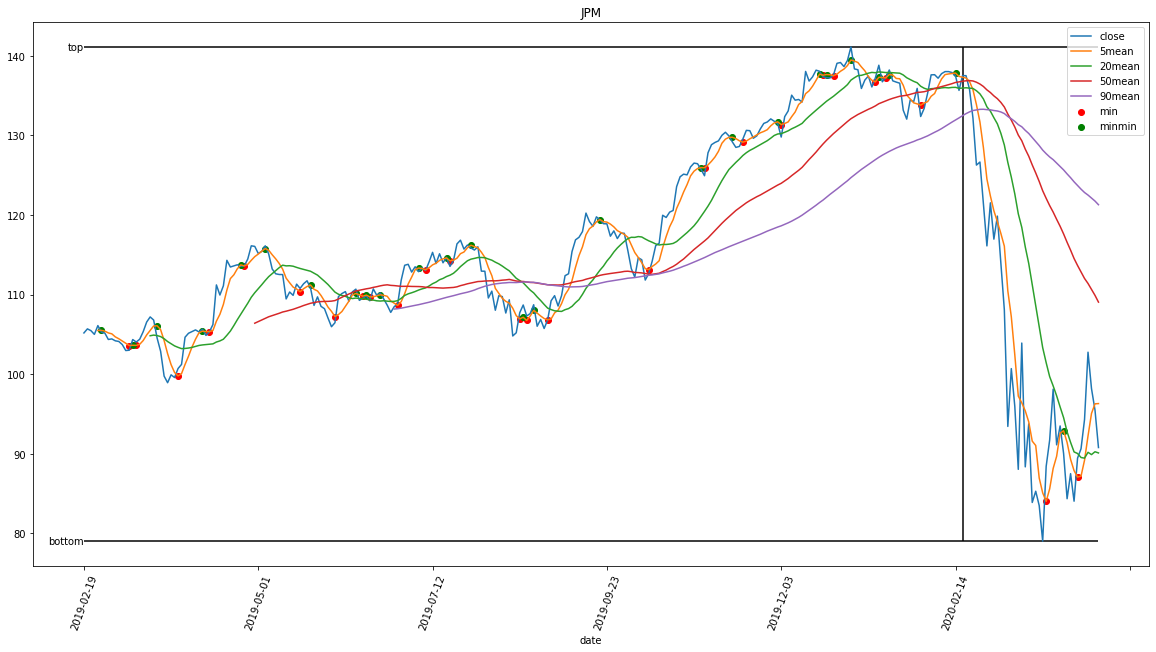

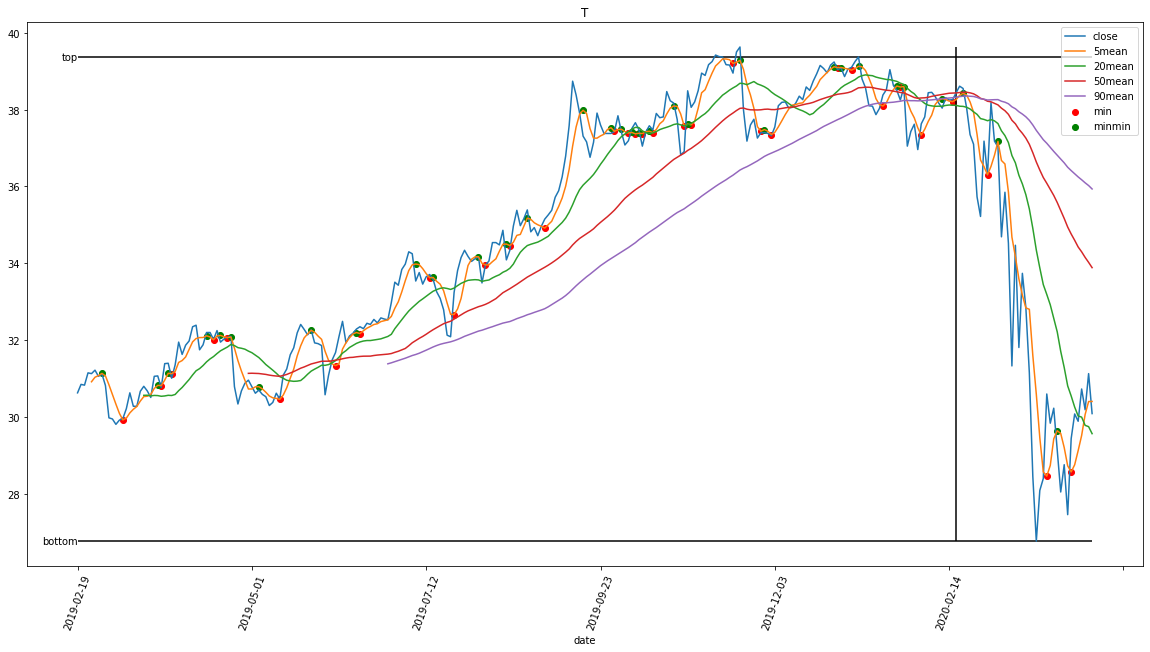

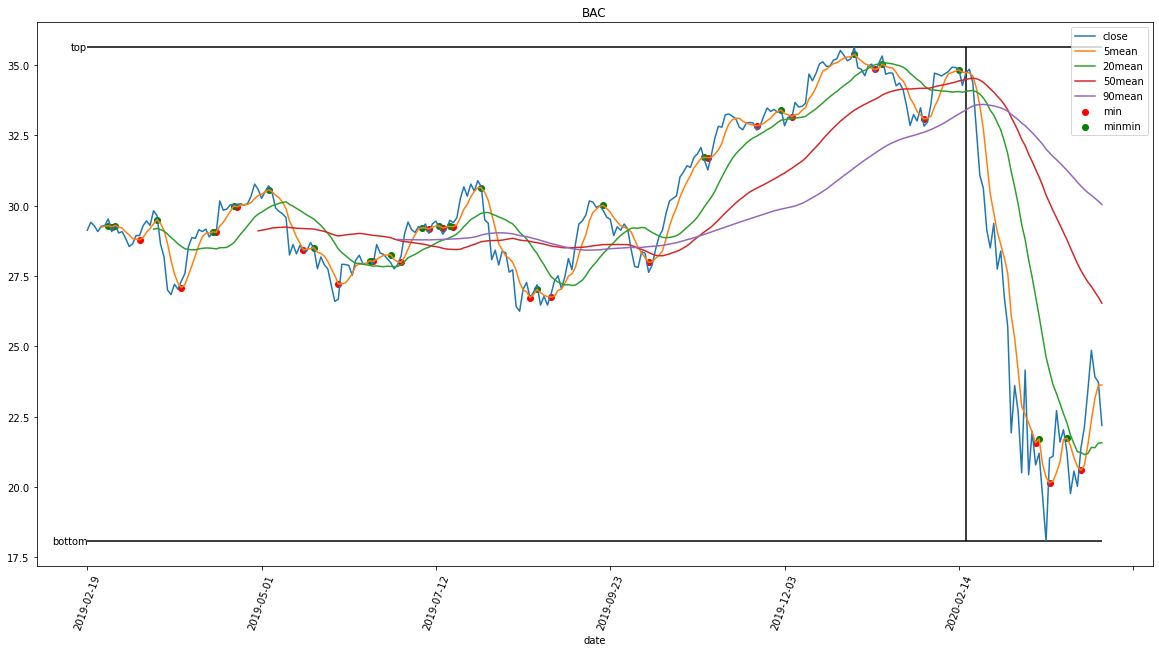

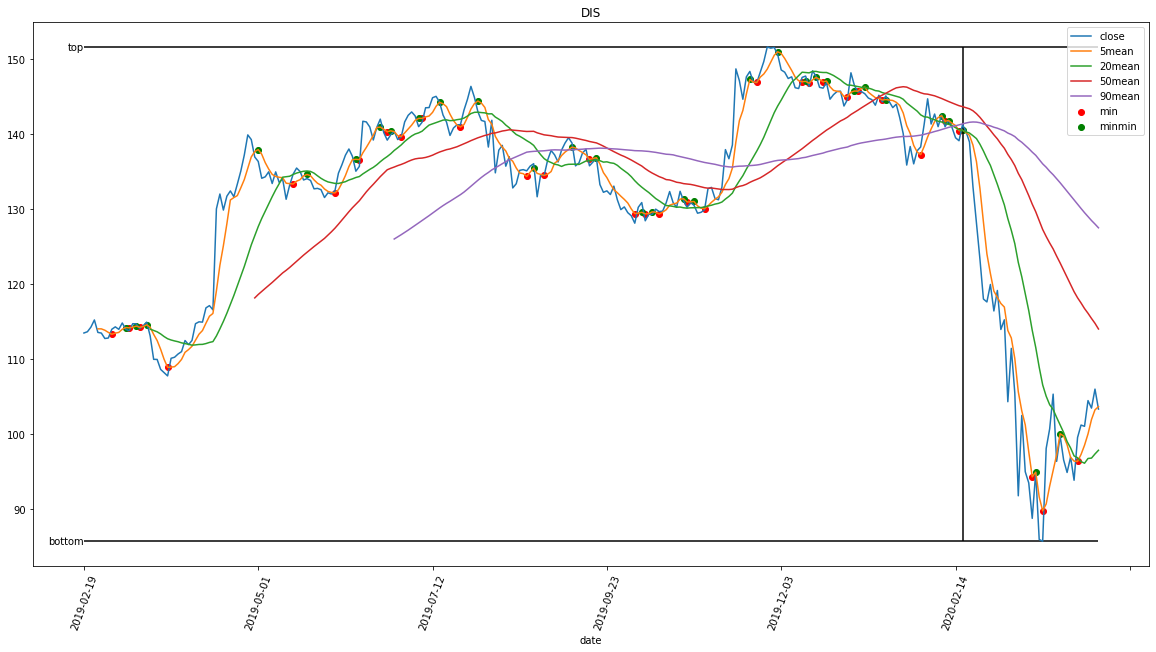

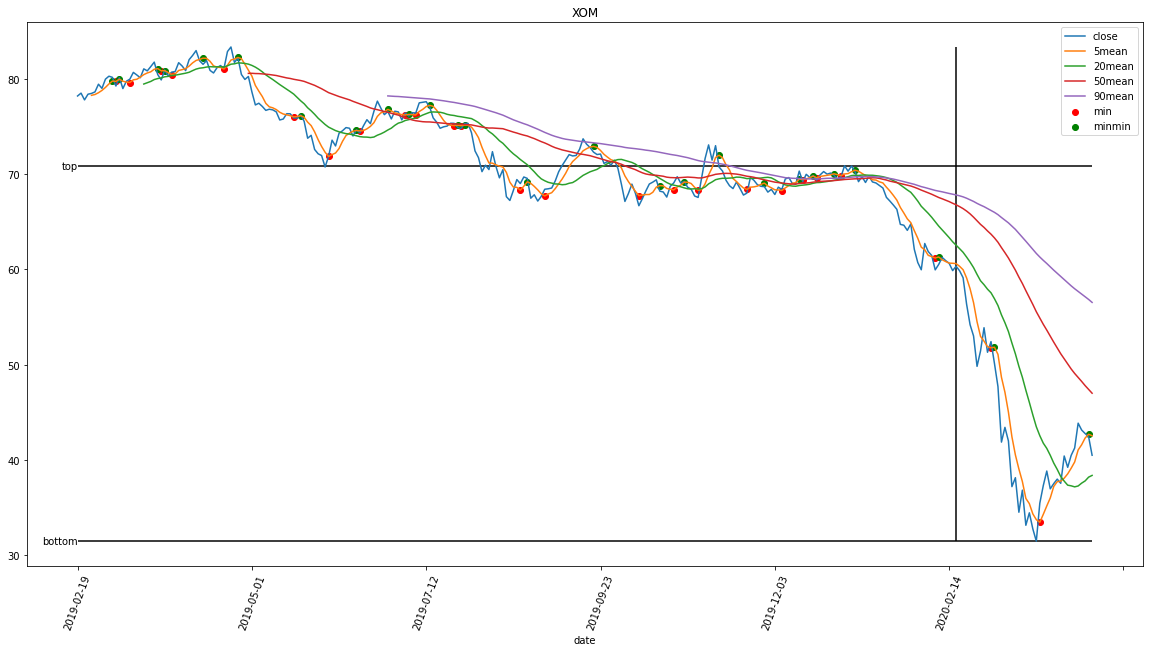

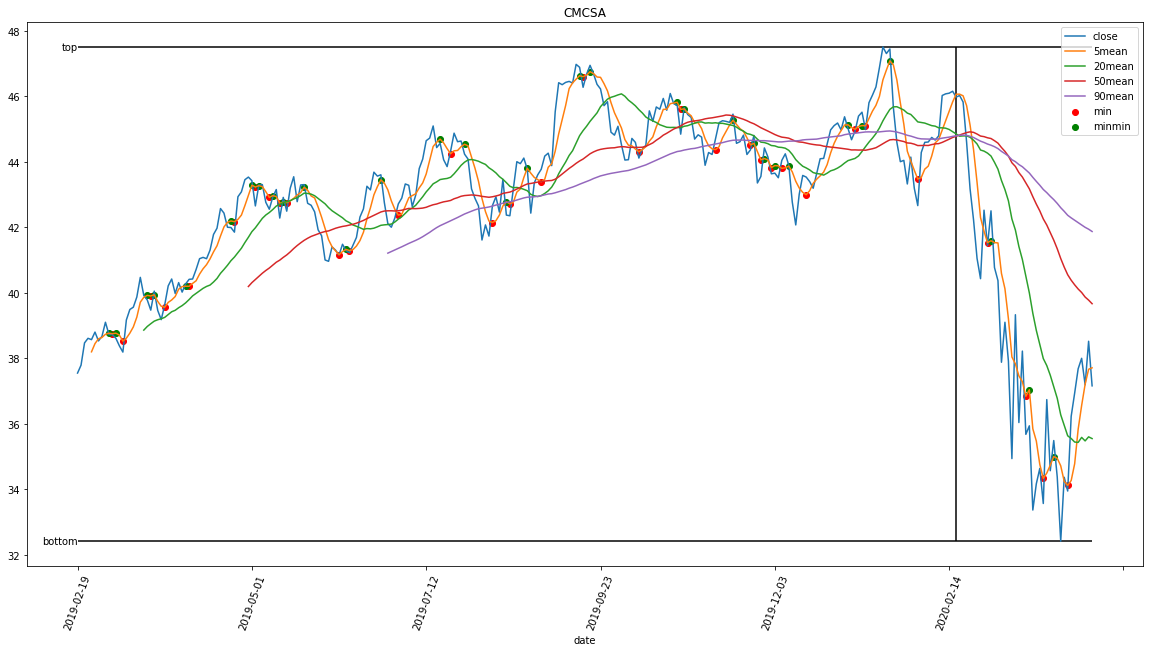

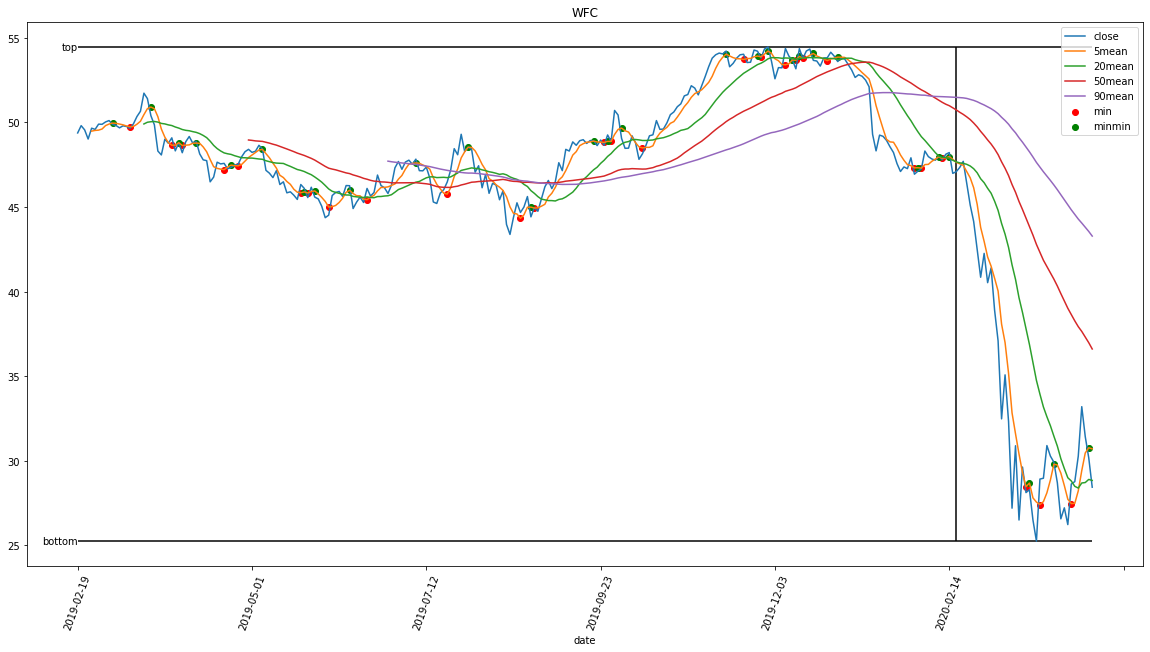

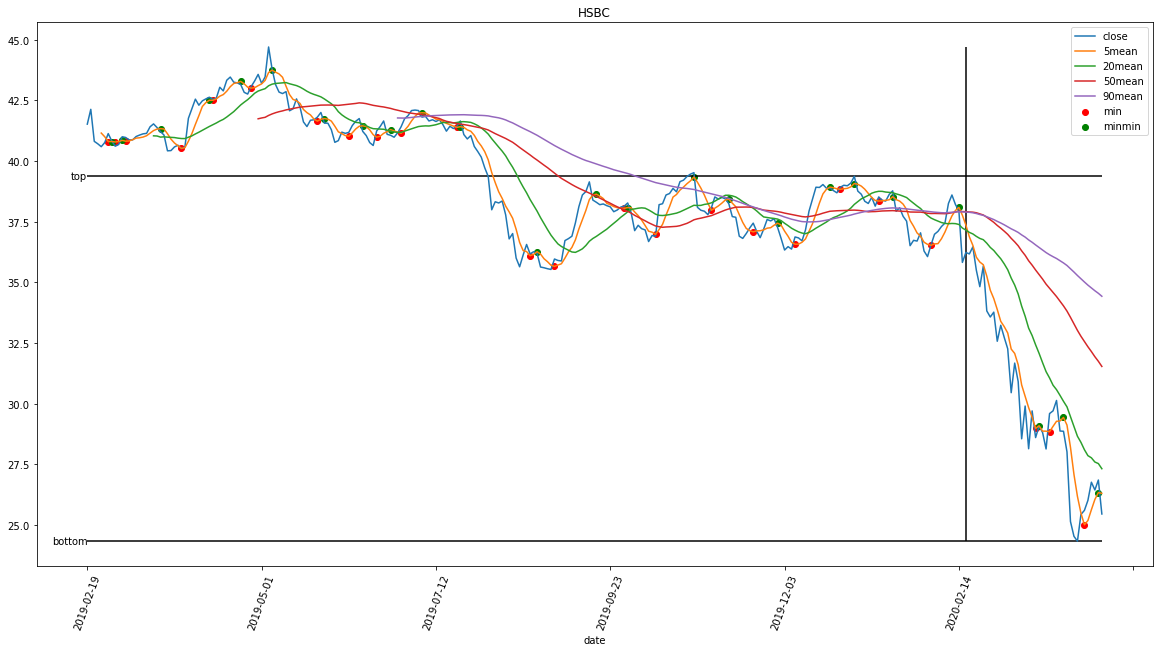

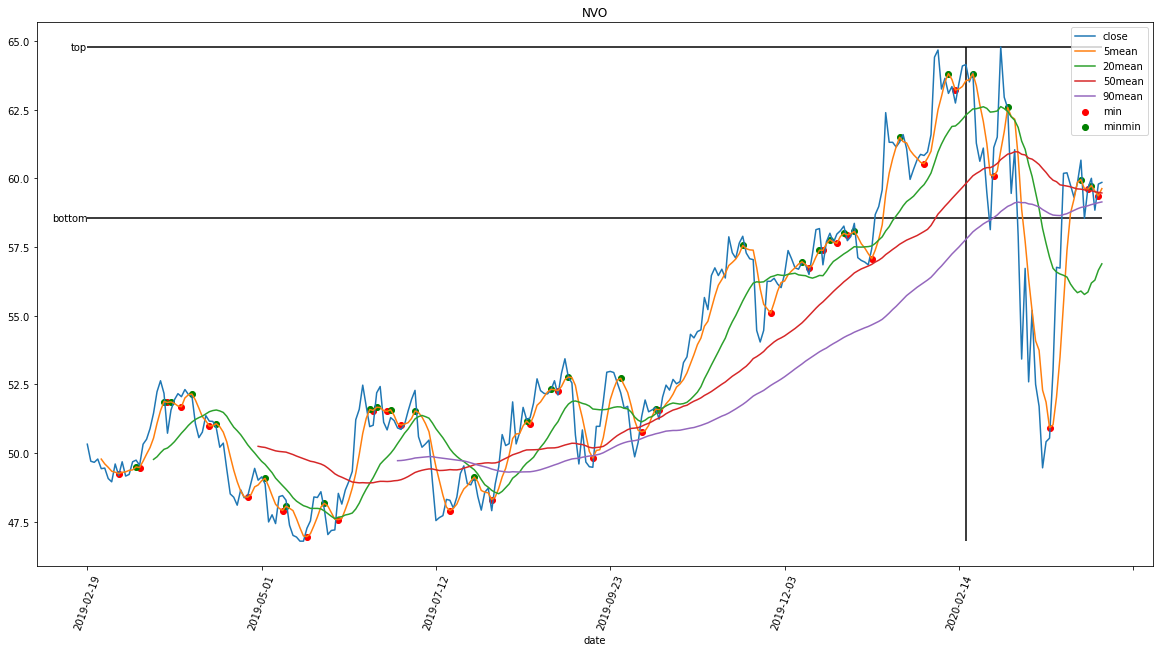

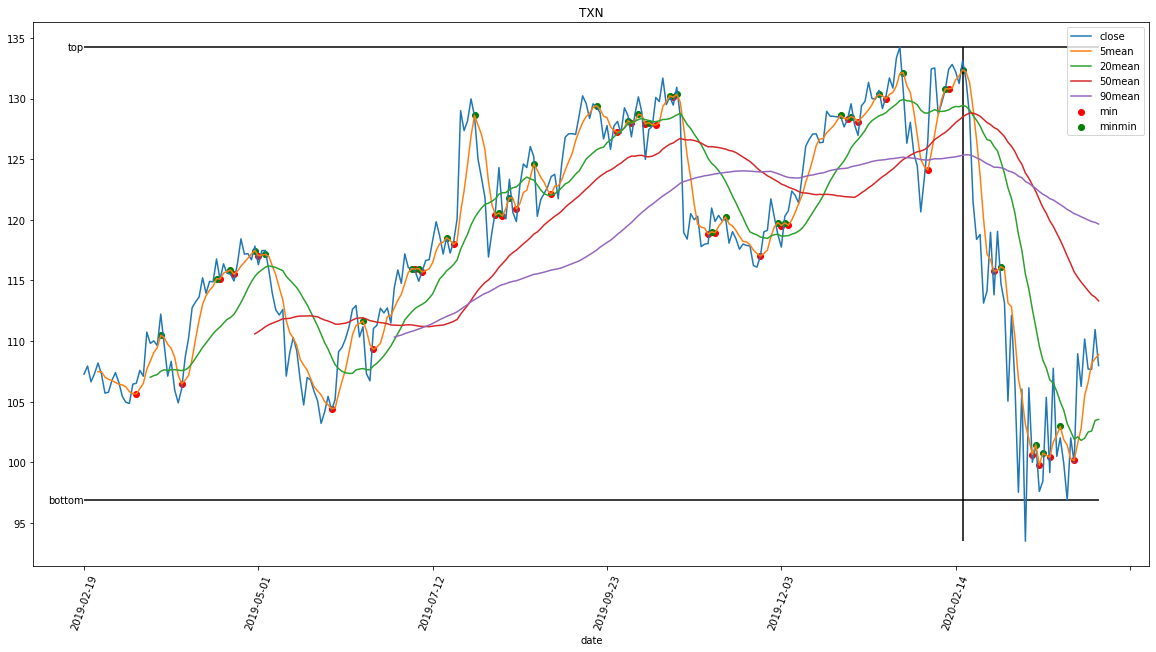

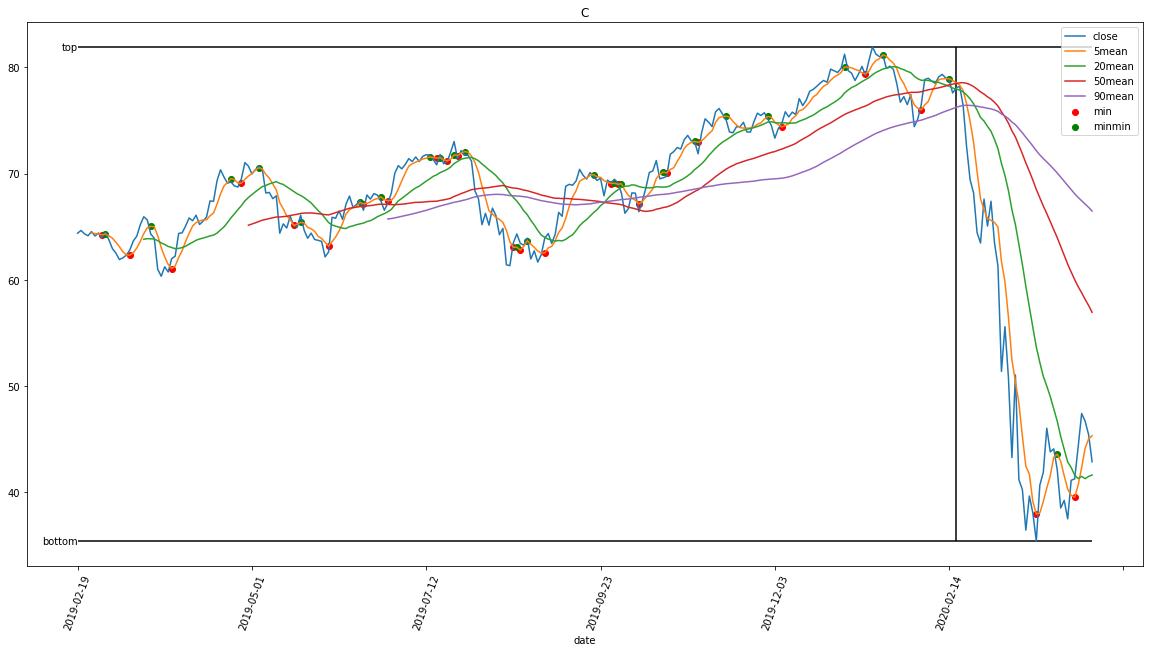

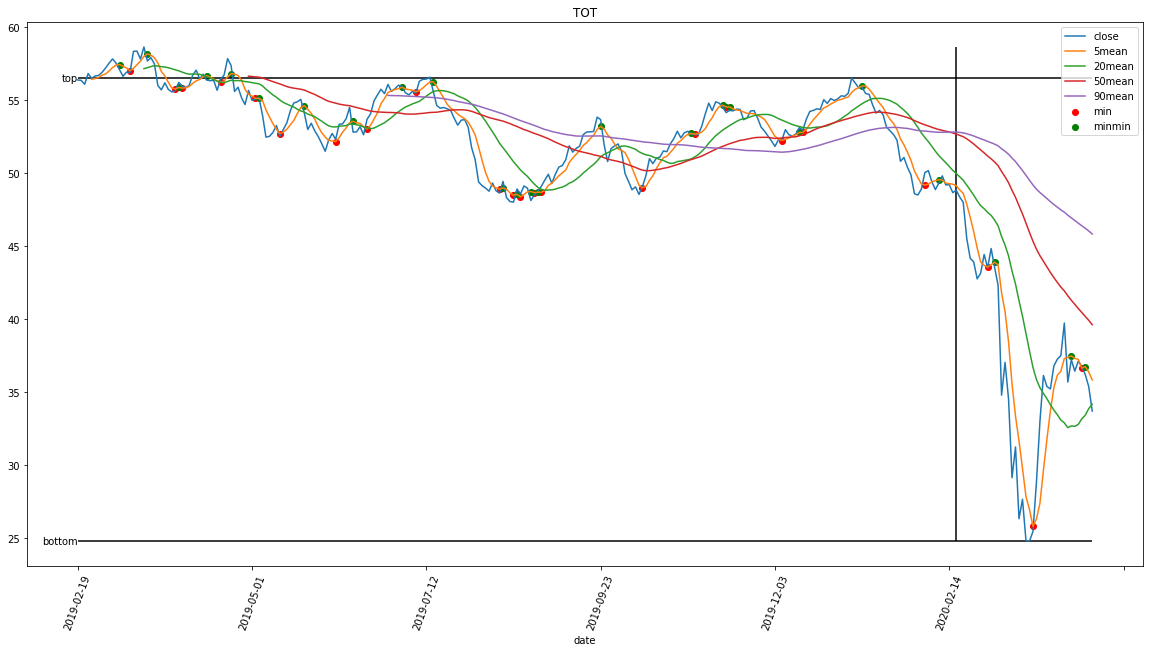

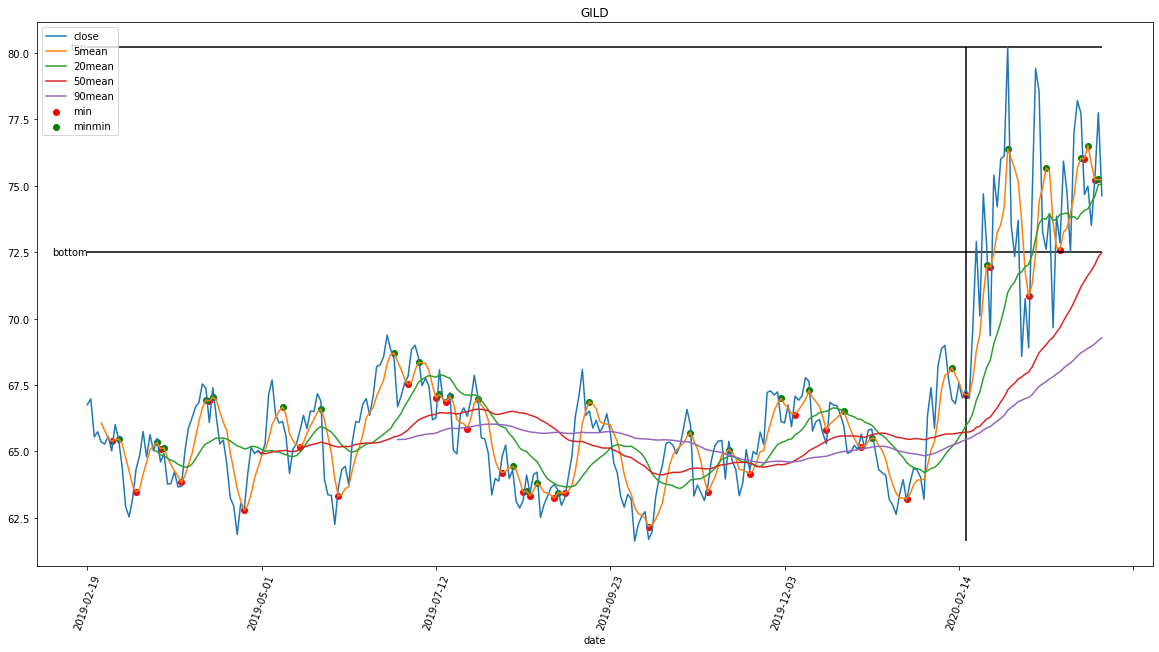

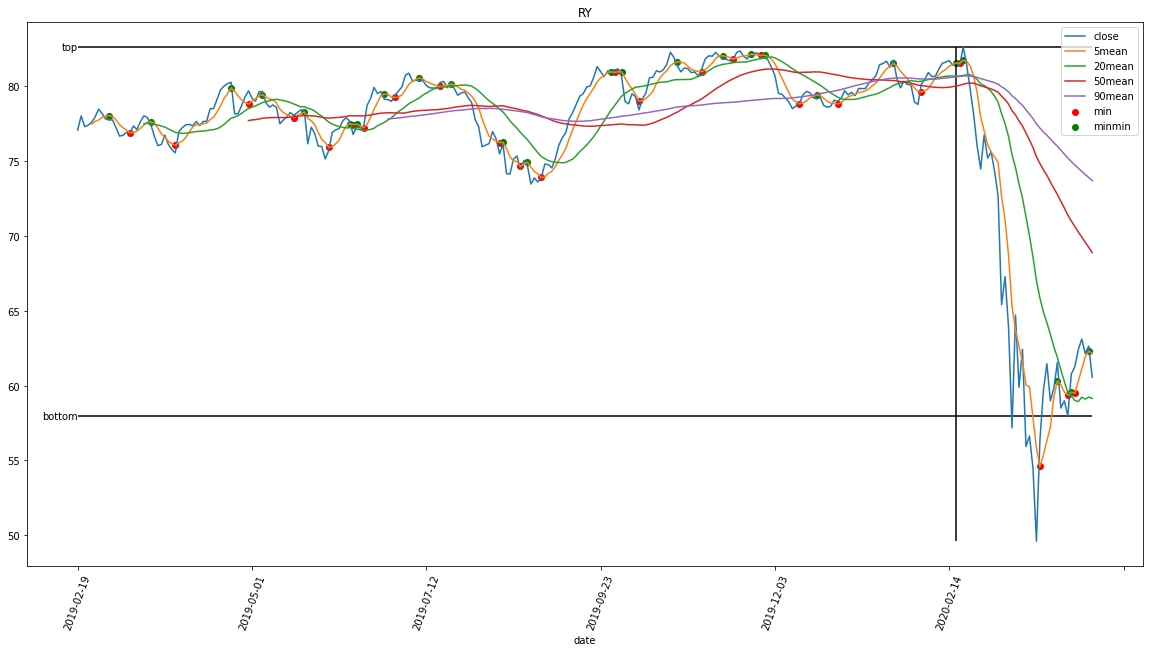

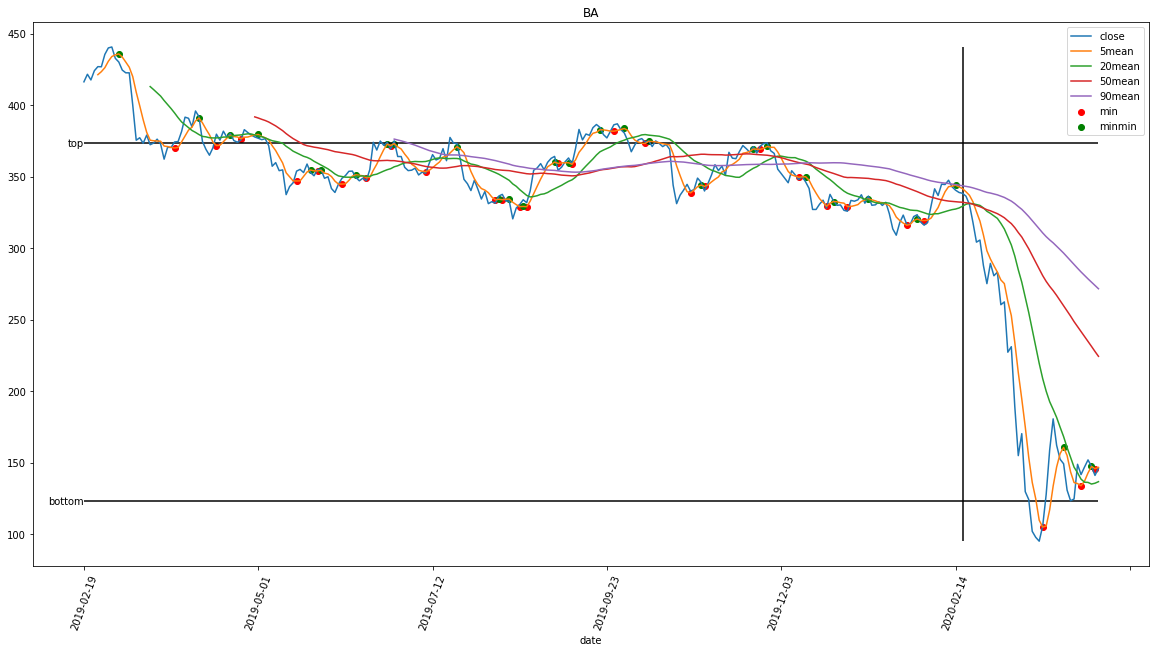

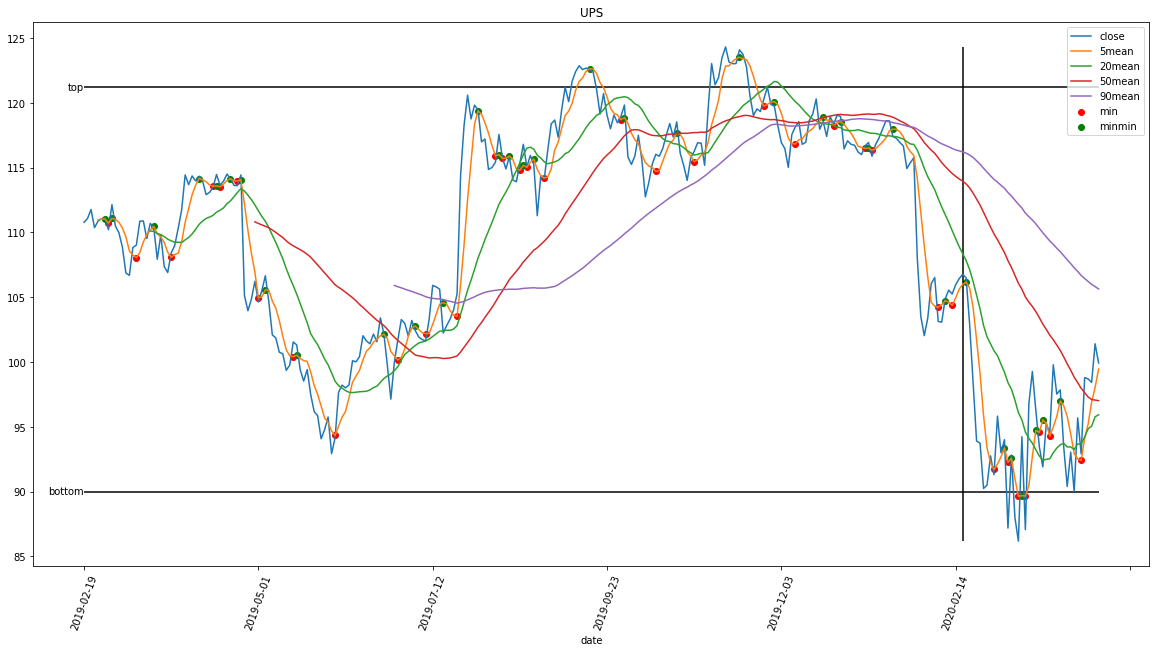

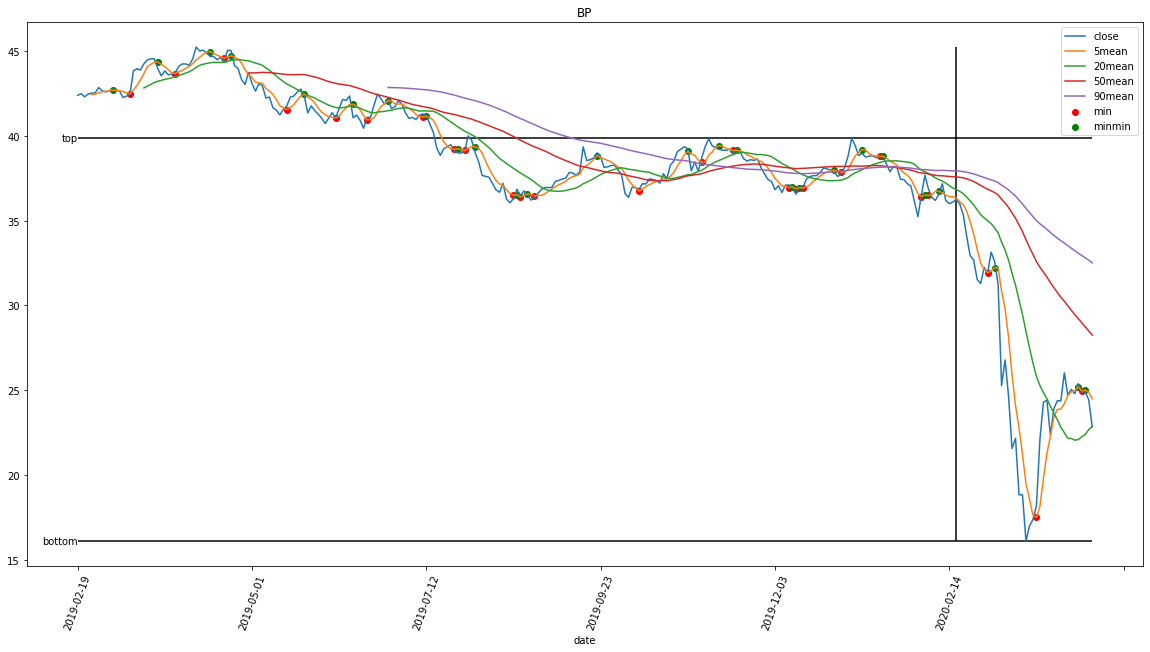

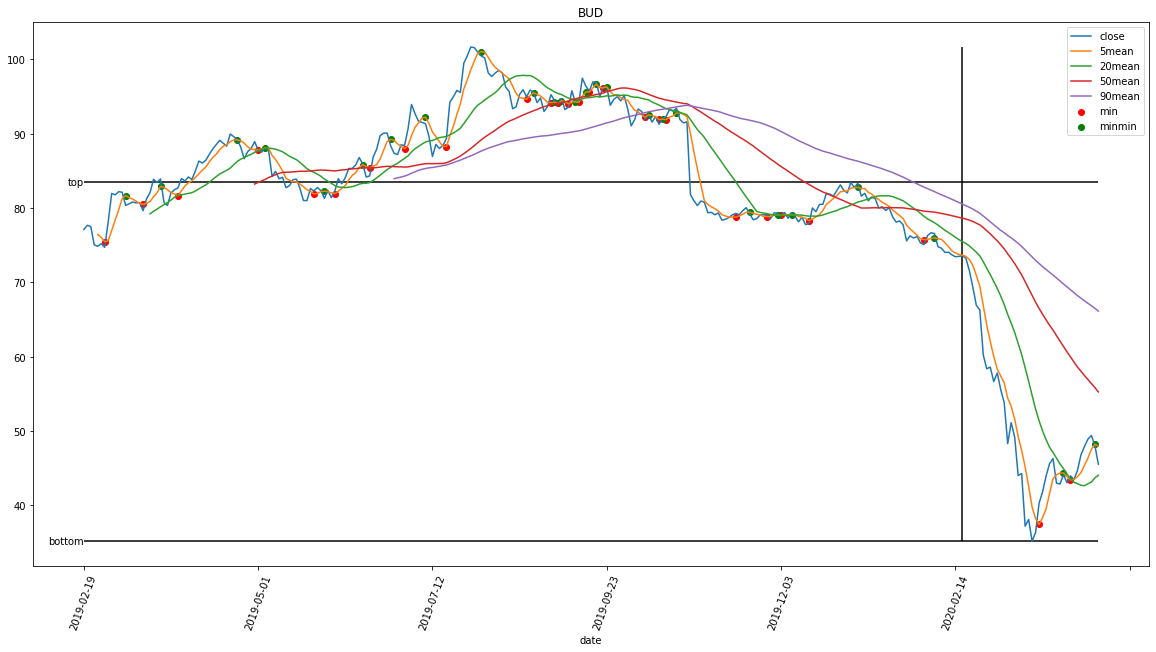

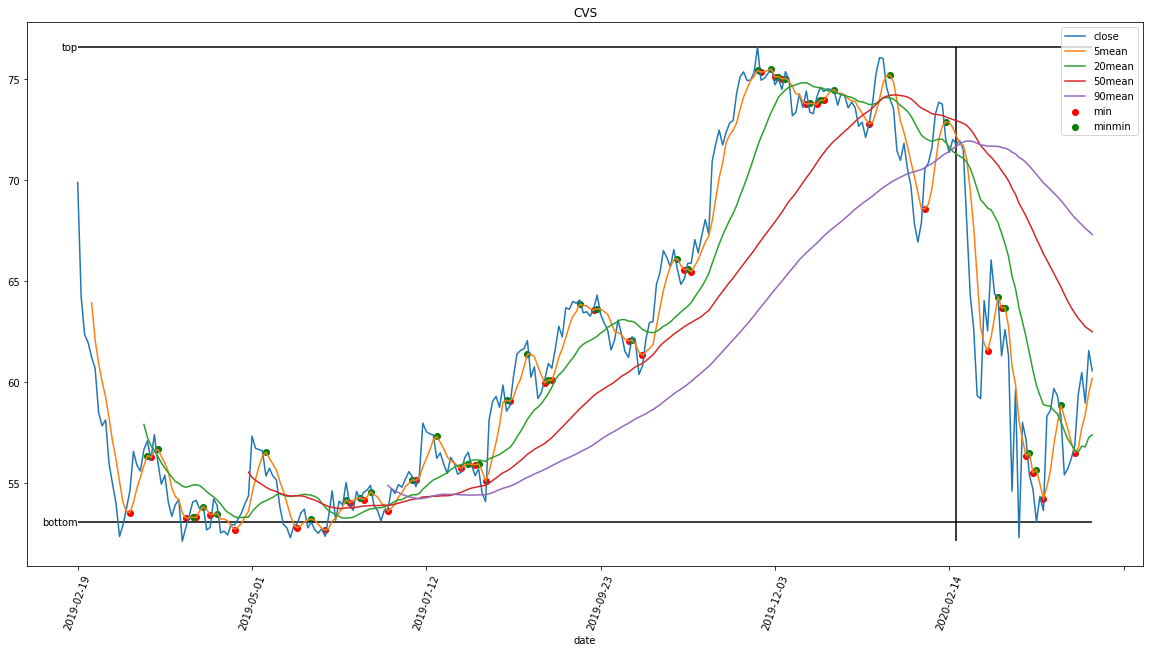

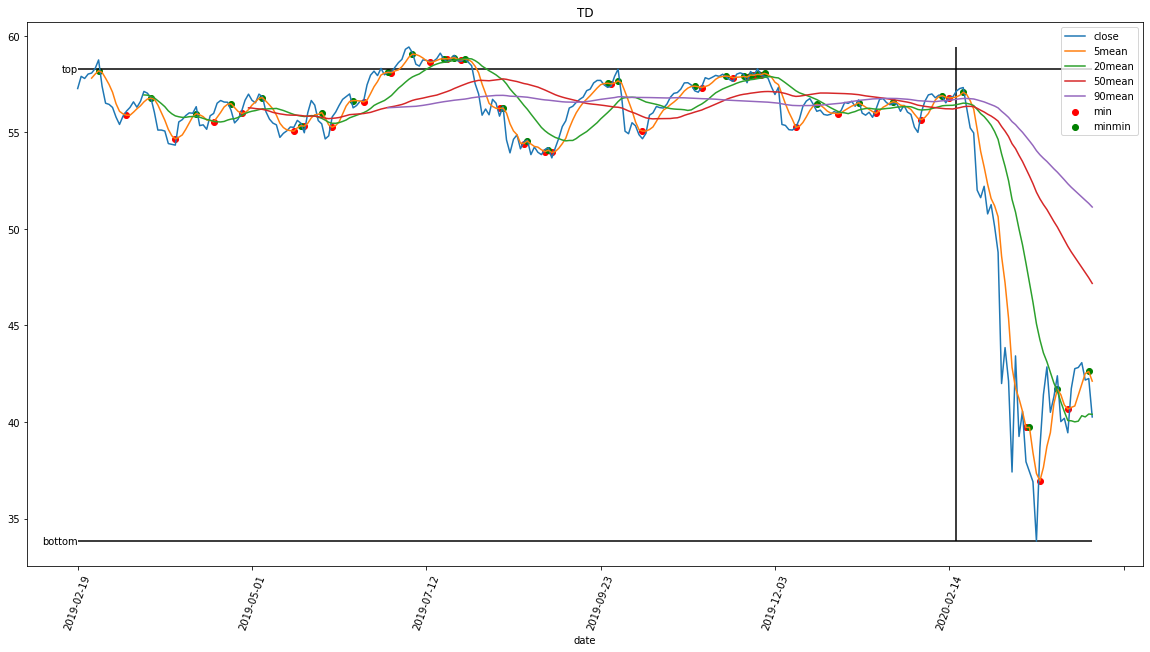

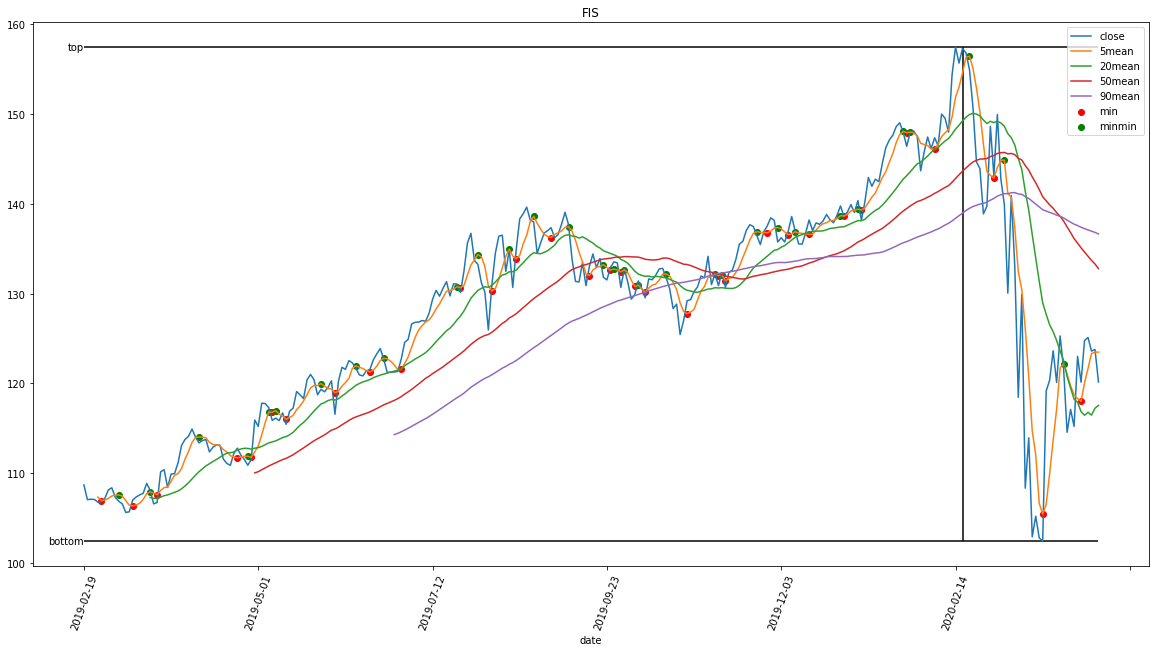

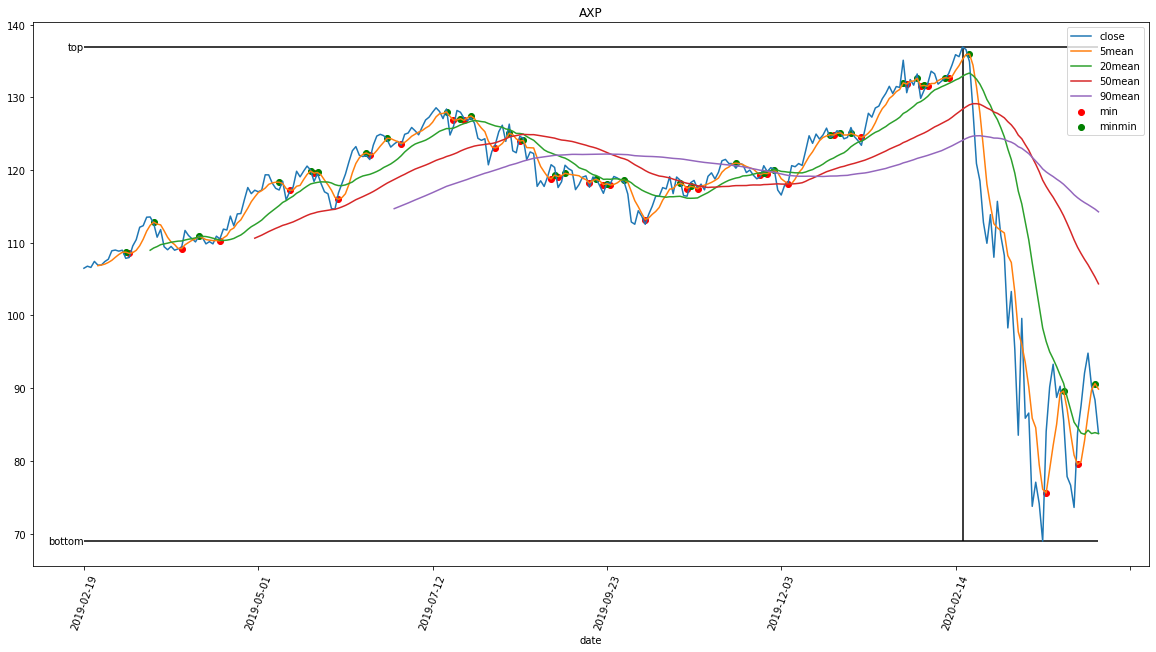

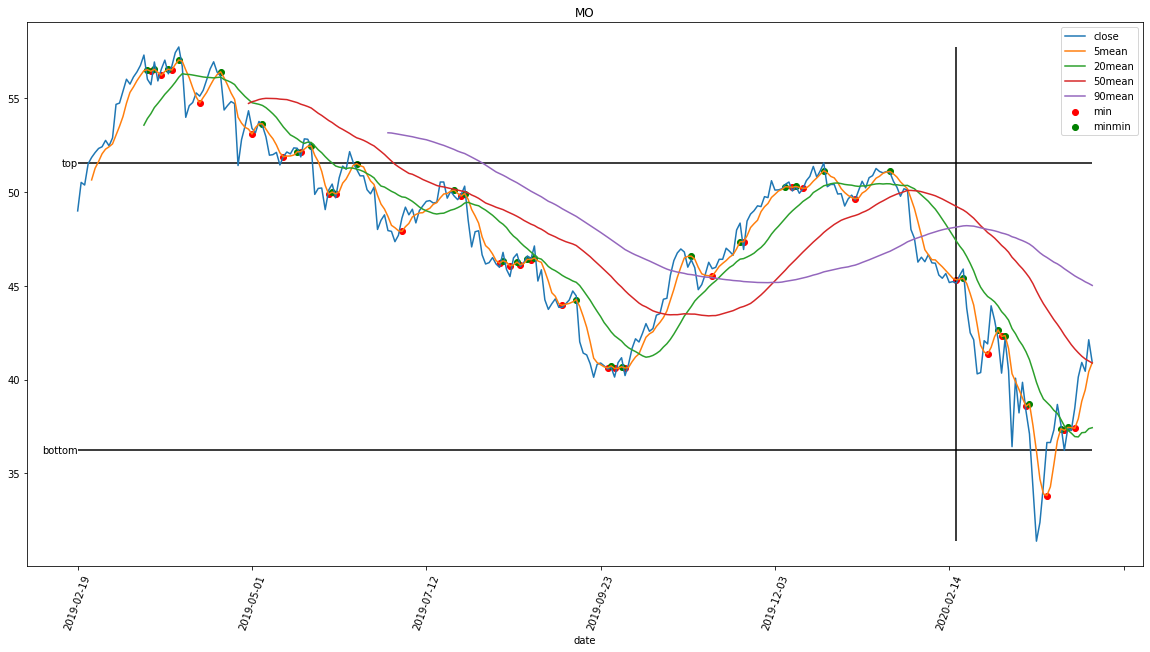

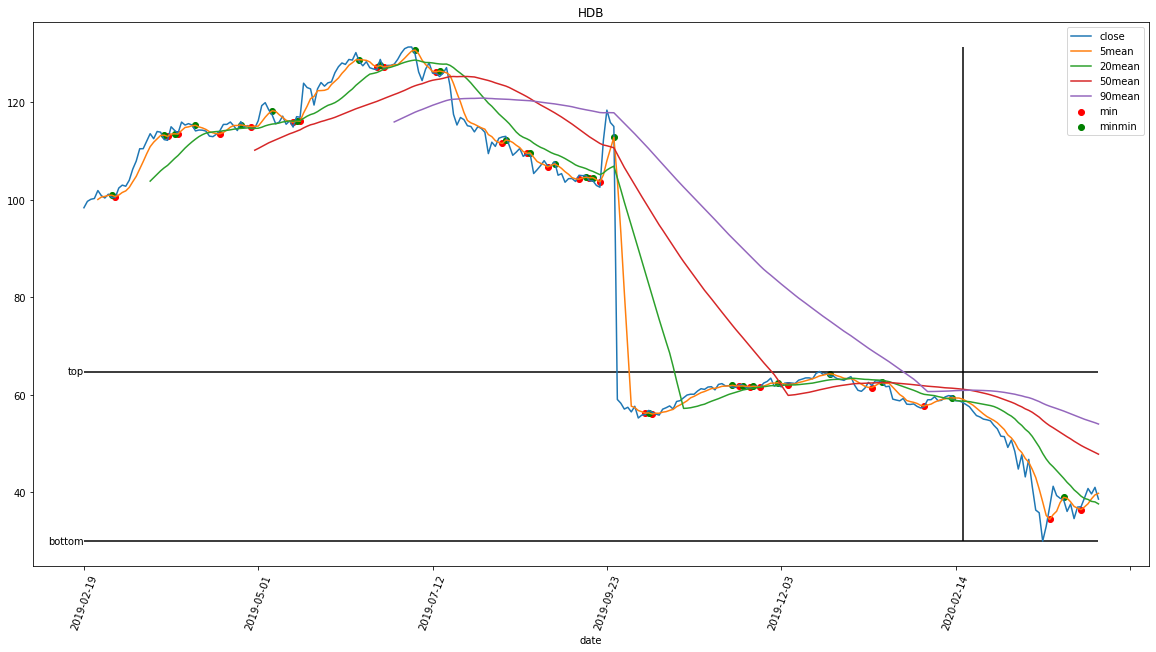

In [106]:
for (sym, rate, indicators, data) in prospects:
    plot_prospect(sym, data, indicators)

In [116]:
print(f"{len(prospects)} prospects")
print([symbol for (symbol, _, _, _) in prospects])

24 prospects
['JPM', 'T', 'BAC', 'DIS', 'XOM', 'CMCSA', 'WFC', 'HSBC', 'NVO', 'TXN', 'C', 'TOT', 'GILD', 'RY', 'BA', 'UPS', 'BP', 'BUD', 'CVS', 'TD', 'FIS', 'AXP', 'MO', 'HDB']
